In [1]:
pip install timm torch torchvision matplotlib scikit-learn


In [2]:
import zipfile
import os

zip_path = "/content/archive (2).zip"  # Change this to your actual path
extract_path = "/content/Data/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")


Dataset extracted successfully!


In [3]:
import os

train_dir = "/content/Data/Data/train"
class_folders = os.listdir(train_dir)
print("Original Class Names:", class_folders)


Original Class Names: ['large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


In [4]:
class_mapping = {
    'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 'adenocarcinoma',
    'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 'large.cell.carcinoma',
    'normal': 'normal',
    'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 'squamous.cell.carcinoma'
}


In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import timm  # Pretrained models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


In [6]:
image_size = 224  # Swin Transformer input size

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),  # Augmentation
    transforms.RandomRotation(10),  # Augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [7]:
class_mapping = {
    'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 'adenocarcinoma',
    'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 'large.cell.carcinoma',
    'normal': 'normal',
    'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 'squamous.cell.carcinoma'
}


In [8]:
# Define dataset paths
train_dir = "/content/Data/Data/train"
valid_dir = "/content/Data/Data/valid/"
test_dir = "/content/Data/Data/test/"
from torchvision.datasets import ImageFolder
# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=train_transform)
valid_dataset = ImageFolder(root=valid_dir, transform=test_transform)
test_dataset = ImageFolder(root=test_dir, transform=test_transform)

# Rename dataset classes
def rename_classes(dataset, class_mapping):
    # Map old labels to new ones
    dataset.class_to_idx = {class_mapping[k]: v for k, v in dataset.class_to_idx.items() if k in class_mapping}
    dataset.classes = list(class_mapping.values())

rename_classes(train_dataset, class_mapping)
rename_classes(valid_dataset, class_mapping)
rename_classes(test_dataset, class_mapping)

# Print updated class labels
print("Updated Class Names:", train_dataset.classes)  # Should print: ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


Updated Class Names: ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


In [9]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Verify class indices
print("Class to Index Mapping:", train_dataset.class_to_idx)


Class to Index Mapping: {'adenocarcinoma': 0, 'large.cell.carcinoma': 1, 'normal': 2, 'squamous.cell.carcinoma': 3}


In [10]:
# Define class names from the processed dataset
class_names = train_dataset.classes  # This will be ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

# Print to verify
print("Class Names:", class_names)

# Load Swin Transformer model
import timm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=len(class_names))
model = model.to(device)

print("Swin Transformer model loaded successfully!")


Class Names: ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Swin Transformer model loaded successfully!


In [11]:
import torch.optim as optim
import torch.nn as nn

# Define loss function (CrossEntropy for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Define optimizer (AdamW works well for transformers)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Print to verify
print("Optimizer and Loss Function initialized successfully!")


Optimizer and Loss Function initialized successfully!


In [12]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss / len(valid_loader)
    val_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/10], Train Loss: 1.0416, Train Acc: 50.08%, Val Loss: 0.9921, Val Acc: 47.22%
Epoch [2/10], Train Loss: 0.7195, Train Acc: 67.54%, Val Loss: 0.9287, Val Acc: 52.78%
Epoch [3/10], Train Loss: 0.5185, Train Acc: 79.28%, Val Loss: 0.9202, Val Acc: 61.11%
Epoch [4/10], Train Loss: 0.3987, Train Acc: 82.06%, Val Loss: 0.7808, Val Acc: 63.89%
Epoch [5/10], Train Loss: 0.2653, Train Acc: 90.86%, Val Loss: 0.5472, Val Acc: 77.78%
Epoch [6/10], Train Loss: 0.2318, Train Acc: 90.70%, Val Loss: 0.4600, Val Acc: 84.72%
Epoch [7/10], Train Loss: 0.1403, Train Acc: 95.76%, Val Loss: 0.3304, Val Acc: 86.11%
Epoch [8/10], Train Loss: 0.1020, Train Acc: 95.92%, Val Loss: 0.5866, Val Acc: 83.33%
Epoch [9/10], Train Loss: 0.1020, Train Acc: 96.08%, Val Loss: 0.6514, Val Acc: 79.17%
Epoch [10/10], Train Loss: 0.1188, Train Acc: 95.92%, Val Loss: 0.6646, Val Acc: 81.94%


<Figure size 800x600 with 0 Axes>

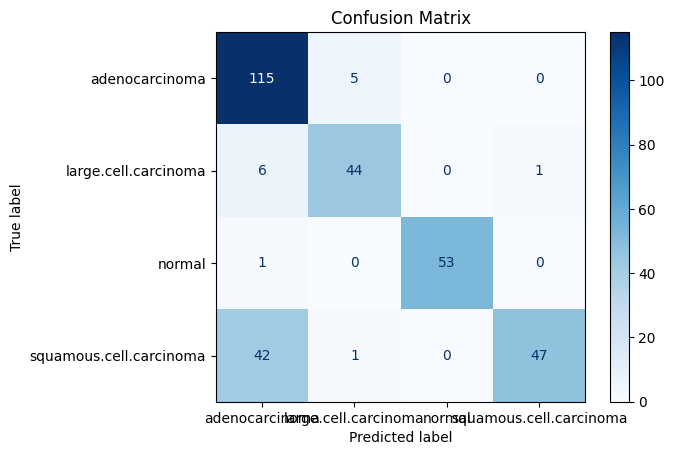

In [13]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot confusion matrix
plt.figure(figsize=(8,6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [14]:
torch.save(model.state_dict(), "swin_transformer.pth")
print("Model saved successfully!")


Model saved successfully!
